In [170]:
# Setup

%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import matplotlib.pyplot as plt
import torch

from bliss.inference import SDSSFrame
from bliss.datasets import sdss
from bliss.inference import reconstruct_scene_at_coordinates
from case_studies.sdss_galaxies.plots.main import load_models


from astropy.table import Table

import plotly.express as px
import plotly.graph_objects as go

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [171]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])
    

In [172]:
single_prior = instantiate(cfg.datasets.sdss_galaxies.prior)
single_decoder = instantiate(cfg.datasets.sdss_galaxies.decoder)

In [173]:
from bliss.models.galsim_decoder import UniformGalsimGalaxiesPrior
prior = UniformGalsimGalaxiesPrior(single_prior, max_n_sources=5, max_shift=0.5)

In [194]:
# check samples look OK 
sample = prior.sample()

# COMMENT OUT for checking what happens when two sources fall in one tile
# sample['locs'][1, :] = sample['locs'][0, :] + 0.01
print(sample)


{'n_sources': tensor(3), 'galaxy_params': tensor([[1.6128e+04, 6.8326e-01, 5.0649e+00, 9.3431e-01, 1.2483e+00, 2.0879e-01,
         5.1694e-01],
        [3.1437e+04, 7.4605e-01, 4.6785e+00, 8.2543e-01, 1.2233e+00, 9.2866e-01,
         4.9414e-01],
        [9.4932e+03, 5.7933e-01, 3.4659e+00, 9.2548e-01, 3.3823e+00, 7.7547e-01,
         8.3646e-01],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00]]), 'locs': tensor([[0.7943, 0.2293],
        [0.1679, 0.0022],
        [0.4243, 0.0479],
        [0.0000, 0.0000],
        [0.0000, 0.0000]]), 'galaxy_bools': tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.]]), 'star_bools': tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])}


In [195]:
# now load full decoder
from bliss.models.galsim_decoder import GalsimGalaxiesDecoder
slen = 40
bp = 12
decoder = GalsimGalaxiesDecoder(single_decoder, slen, bp)

In [196]:
# turn sample to FullCatalog
from bliss.catalog import FullCatalog
params_dict = {**sample}
params_dict["plocs"] = params_dict["locs"] * slen
params_dict.pop('locs')
params_dict = {k: v.unsqueeze(0) for k, v in params_dict.items()}
full_cat = FullCatalog(slen, slen, params_dict)
print(full_cat['galaxy_bools'].shape)
print(full_cat.n_sources.shape)

torch.Size([1, 5, 1])
torch.Size([1])


In [197]:
tile_slen = 4
max_tile_n_sources = 1
tile_cat = full_cat.to_tile_params(tile_slen, max_tile_n_sources)
tile_cat['galaxy_bools'].shape

torch.Size([1, 10, 10, 1, 1])

In [198]:
images, centered, uncentered = decoder(full_cat)

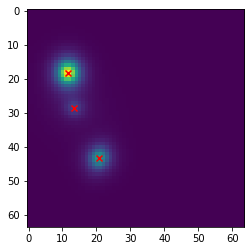

In [199]:
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')

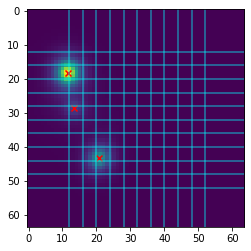

In [200]:
# tiles (blue squares)
plocs_numpy = full_cat.plocs.numpy()
n_sources = full_cat.n_sources.item()
plt.imshow(images[0].numpy())
plt.scatter(plocs_numpy[0, :n_sources, 1] + decoder.bp - 0.5, plocs_numpy[0, :n_sources, 0] + decoder.bp - 0.5, marker='x', c='r')
for x,y in zip(np.arange(0, slen+tile_slen, tile_slen) + bp, np.arange(0, slen+tile_slen, tile_slen) + bp): 
    plt.axvline(x, c='cyan', alpha=0.5)
    plt.axhline(y, c='cyan', alpha=0.5)

In [201]:
tile_cat.n_sources # should correspond to above squares

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [202]:
tile_cat['galaxy_params'][0, :, :, 0, 0] # should correspond to above squares

tensor([[    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [31436.7324,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [ 9493.1836,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,
             0.0000,     0.0000,     0.0000,     0.0000],
        [    0.0000,     0.

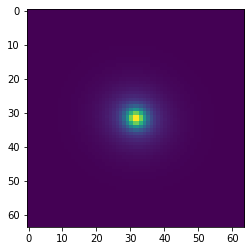

In [204]:
plt.imshow(centered[2, 0].numpy())

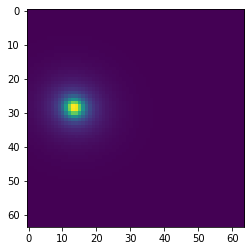

In [205]:
plt.imshow(uncentered[2, 0].numpy())

In [206]:
# now dataset 
from bliss.datasets.galsim_galaxies import GalsimBlends
from bliss.datasets.background import ConstantBackground
background = ConstantBackground((860.,))
ds = GalsimBlends(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=2)

In [207]:
# get one sample from dataset
print(ds[0]['galaxy_bools'].shape)
print(ds[0]['n_sources'].shape)

torch.Size([10, 10, 1, 1])
torch.Size([10, 10])


In [ ]:
x['n_sources']

torch.Size([5, 10, 10])
torch.Size([5, 1, 64, 64])

torch.Size([5, 10, 10])
torch.Size([5, 1, 64, 64])



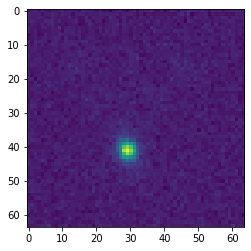

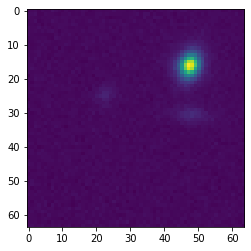

In [234]:
# now a batch 
for x in ds.train_dataloader():
    print(x['n_sources'].shape)
    print(x['images'].shape)
    print()
    plt.figure()
    plt.imshow(x['images'][0, 0].numpy()) # plot first figure of each batch.